# Reinforcement Learning
Prof. M. Gašić

### REINFORCE

In general, the update rule of policy gradient can be written as:
$$
w \leftarrow w + \alpha \, \Phi_t \nabla_w \log \pi_w(a_t | s_t)
$$
where $w$ is the weight vector, $\alpha$ is the learning rate, and $\Phi_t \in \mathbb{R}$ indicates how good it was to select the action $a_t$ in the state $s_t$.  
The default REINFORCE algorithm uses $\Phi_t = \gamma^t g_t$, i.e., the discounted return (calculated with a Monte Carlo sample).  

As we will see in the lecture, there are other valid options for $\Phi_t$ that have lower variance.  
In this notebook, we will use $\Phi_t = \gamma^t (g_t - b)$, where $b$ (baseline) is the average of all returns that we have seen so far.  

Your task is to implement the following algorithm.

**REINFORCE with average return baseline:**
- Initialize counter: $N \leftarrow 0$
- Initialize baseline: $b \leftarrow 0$
- Loop forever:
  - Generate an episode $s_0, a_0, r_1, \ldots, s_{T-1}, a_{T-1}, r_T$ following $\pi_w$
  - Initialize return: $g \leftarrow 0$
  - For $t = T - 1, \ldots, 0$:  
    - Compute return: $g \leftarrow r_{t + 1} + \gamma g$
    - Increment counter: $N \leftarrow N + 1$
    - Update baseline: $b \leftarrow b + (g - b) / N$
    - Update weights: $w \leftarrow w + \alpha \, \gamma^t (g - b) \, \nabla_w \log \pi_w(a_t | s_t)$

#### Softmax Policy

In this notebook, we will implement a linear softmax policy, i.e.,
$$
\pi_w(a | s) = \frac{\exp\left( x(s, a)^\top w \right)}{\sum_{a'} \exp\left( x(s, a')^\top w \right)},
$$
where $x(s, a) \in \mathbb{R}^d$ is a feature vector of the state and action, and $w \in \mathbb{R}^d$ is a weight vector.

The score function of this policy, which is required for the REINFORCE algorithm, can be computed with
$$
\nabla_w \log \pi_w(a | s) = x(s, a) - \sum_{a'} \pi(a' | s) \, x(s, a').
$$

We will use the following features:
$$
x(s, a) = [\ \underbrace{0, \ldots, 0}_{D \,\cdot\, a},\ s, \underbrace{0, \ldots, 0}_{D \,\cdot\, (M - a - 1)}]^\top \in \mathbb{R}^{D \,\cdot\, M}
$$
where $s \in \mathbb{R}^D$, $a \in \{0, \ldots, M - 1\}$.  
In other words, we put the entire state vector at a different location depending on the action, and fill the rest with zeros.  
This has the effect that $x(s, a)^\top w$ will use a different set of weights for each action, as the other ones are multiplied by zero.

### Implementation

Make sure that the files `rl_gui.py` and `rl_tests.py` are in the same folder as the notebook.

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

import rl_gui
import rl_tests

We already implemented the features as described above:

In [2]:
class ActionFeatures:

    def __init__(self, observation_space, action_space):
        # check state space
        if not (isinstance(observation_space, gym.spaces.Box) and len(observation_space.shape) == 1):
            raise ValueError('Observation space must be a real-valued vector')

        # check action space
        if not isinstance(action_space, gym.spaces.Discrete):
            raise ValueError('Action space must be discrete')

        self.state_dim = observation_space.shape[0]
        self.num_actions = action_space.n

    def __call__(self, state, action):
        state_dim = self.state_dim
        # create vector with zeros
        x = np.zeros(state_dim * self.num_actions, dtype=np.float32)
        # copy state into its slot
        i = action * state_dim
        x[i:i + state_dim] = state
        return x

We will use the following base class for learned policies:

In [3]:
class Policy:

    def select_action(self, state):
        # sample an action from pi(. | state)
        raise NotImplementedError()

    def score_function(self, state, action):
        # compute gradient of log pi(action | state)
        raise NotImplementedError()

    def update(self, state, action, advantage):
        # update the weights for the given state and action, weighted by the advantage
        raise NotImplementedError()

The following class implements softmax policies as described above.  
The learning rate `alpha` is also part of the policy.  
The parameter `feature_fn` is a function that computes a feature vector for a given state and action.

In [4]:
class SoftmaxLinearPolicy(Policy):

    def __init__(self, observation_space, action_space, alpha, feature_fn, rng=None):
        super().__init__()
        self.alpha = alpha  # learning rate

        # check the action space
        if not isinstance(action_space, gym.spaces.Discrete):
            raise ValueError('Action space must be discrete')
        self.num_actions = action_space.n

        # function that converts a state and action into a feature vector
        self.feature_fn = feature_fn

        # determine the size of the feature vectors
        # sample a random state and action and convert them to a feature vector
        sample_features = feature_fn(observation_space.sample(), action_space.sample())
        if not (isinstance(sample_features, np.ndarray) and len(sample_features.shape) == 1):
            raise ValueError('Features must be real-valued vectors')

        # size of feature vectors
        self.feature_dim = sample_features.shape[0]

        # initialize random number generator
        self.rng = rng if rng is not None else np.random.default_rng()

        # reset the weights
        self.reset()

    def reset(self):
        # create weight vector with size of feature vectors, initialize with zeros
        self.weights = np.zeros(self.feature_dim, dtype=np.float32)

    def compute_probs(self, state):
        # utility function that computes the probabilities pi(. | state) for all actions,
        # it also returns the computed feature vectors
        w = self.weights
        num_actions = self.num_actions
        xs = []  # list of feature vectors for each action
        #######################################################################
        # TODO Compute the action probabilities for the given state using the #
        # softmax as described above. Use self.feature_fn(state, action) to   #
        # compute feature vectors. Also store the feature vectors in the list #
        # `xs`, since they can be reused later.                               #
        #######################################################################

        probs = np.zeros(num_actions)
        for action in range(num_actions):
            x = self.feature_fn(state, action)
            xs.append(x)
            # compute the probability of the action
            probs[action] = np.exp(np.dot(w, x))
        probs /= np.sum(probs)

        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        probs = probs.astype(np.float32, copy=False)
        return probs, xs

    def select_action(self, state):
        # sample an action given a state
        # compute action probabilities
        probs, _ = self.compute_probs(state)
        # sample from the distribution
        action = np.random.choice(self.num_actions, p=probs)
        return action

    def score_function(self, state, action):
        w = self.weights
        num_actions = self.num_actions
        #######################################################################
        # TODO Compute the score function for the given state and action. Use #
        # the function compute_probs() to obtain the probabilities and the    #
        # feature vectors.                                                    #
        #######################################################################

        probs, xs = self.compute_probs(state)
        score = xs[action] - np.dot(probs, xs)

        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        score = score.astype(np.float32, copy=False)
        return score

    def update(self, state, action, advantage):
        w = self.weights
        alpha = self.alpha
        #######################################################################
        # TODO Update the weight vector as described above. (advantage = phi) #
        #######################################################################

        w += alpha * advantage * self.score_function(state, action)

        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        self.weights = w

You can use the following code cell to test your implementation.  
**Important**: After changing your code, execute the above code cell before running the tests.

In [5]:
# new test with fixed expected scores

def test_softmax_policy():
    rng = np.random.default_rng(seed=17)
    obs_space = gym.spaces.Box(np.zeros(3, dtype=np.float32), np.ones(3, dtype=np.float32))
    act_space = gym.spaces.Discrete(4)
    features = ActionFeatures(obs_space, act_space)
    policy = SoftmaxLinearPolicy(obs_space, act_space, 0.07, features, rng=rng)

    sample_state = lambda: rng.uniform(0.0, 1.0, obs_space.shape).astype(np.float32, copy=False)
    sample_action = lambda: rng.choice(act_space.n)

    yield 'compute_probs()'

    policy.weights = rng.standard_normal(policy.weights.shape).astype(np.float32, copy=False)

    for expected_probs in [
        np.array([0.90269875, 0.01361316, 0.04949653, 0.03419157], dtype=np.float32),
        np.array([0.74848235, 0.05044989, 0.12121326, 0.07985448], dtype=np.float32)
    ]:
        state = sample_state()
        probs, xs = policy.compute_probs(state)
        if (yield from rl_tests.check_numpy_array(probs, 'probs', shape=expected_probs.shape, dtype=np.float32)):
            yield np.allclose(probs, expected_probs), \
                f'Computed probabilities are incorrect (error = {np.sum(np.abs(probs - expected_probs))})'

        yield isinstance(xs, list) and len(xs) == act_space.n, \
            f'xs must be a list of length {act_space.n} (got {len(xs)})'
        for a, x in enumerate(xs):
            yield np.allclose(x, features(state, a)), f'xs contains wrong feature vectors (for action {a})'
        yield None

    yield 'score_function()'

    for expected_score in [
        np.array([-0.0542655,  -0.04997427, -0.13998121,  0.14724284,  0.13559912,  0.37982202, -0.03655295, -0.0336624,  -0.09429058, -0.05642439, -0.05196244, -0.1455502 ], dtype=np.float32),
        np.array([-0.31696385, -0.64511997, -0.5715783,  -0.02204133, -0.04486096, -0.03974695, 0.39505485,  0.8040593,   0.7123991,  -0.05604962, -0.1140784,  -0.10107382], dtype=np.float32)
    ]:
        score = policy.score_function(sample_state(), sample_action())
        if (yield from rl_tests.check_numpy_array(score, 'score', shape=expected_score.shape, dtype=np.float32)):
            yield np.allclose(score, expected_score), \
                f'Computed score is incorrect (error = {np.sum(np.abs(score - expected_score))})'
        yield None

    yield 'update()'

    for expected_weights in [
        np.array([-0.20219066, -2.27896578,  2.03422714, -2.17468828, -2.08132293, -1.2758126, 0.55199572,  1.78623307, -0.24874753, -0.38633042,  0.17751255, -0.36193669], dtype=np.float32),
        np.array([-0.1025072,   0.16325331,  0.56471321, -0.81238355, -1.32787222, -0.94905908, 0.52641521, -0.85278105, -0.77391747,  1.15396637, -0.78571158, -0.89402242], dtype=np.float32)
    ]:
        policy.weights = rng.standard_normal(policy.weights.shape)
        policy.update(sample_state(), sample_action(), rng.uniform(-1.0, 1.0))
        yield np.allclose(policy.weights, expected_weights), \
            f'Updated weights are incorrect (error = {np.sum(np.abs(policy.weights - expected_weights))})'
        yield None

rl_tests.run_tests(test_softmax_policy())

Testing compute_probs()...
2/2 tests passed!

Testing score_function()...
2/2 tests passed!

Testing update()...
2/2 tests passed!


### Evaluation

We will evaluate the algorithm on the CartPole environment.

In [7]:
def create_env(seed):
    env_id = f'CartPole-v1'
    env = gym.make(env_id, render_mode='rgb_array')
    env.reset(seed=seed)
    return env

Evaluate a random policy:

DependencyNotInstalled: pygame is not installed, run `pip install "gymnasium[classic-control]"`

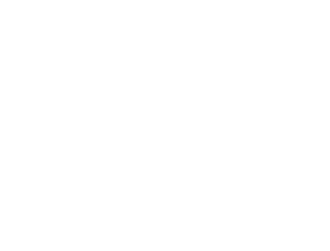

In [8]:
env = create_env(seed=42)
render = rl_gui.create_renderer(env, fps=60, figsize=(4, 3))

env.reset()
render()
reward_sum = 0.0
while True:
    action = env.action_space.sample()
    _, reward, terminated, truncated, _ = env.step(action)
    reward_sum += reward
    render(f'sum of rewards: {reward_sum:.1f}')
    if terminated or truncated:
        break

Train the policy using REINFORCE.  
You can play around with the hyperparameters and try to find a better solution.

In [6]:
alpha = 0.00015      # learning rate
gamma = 1.0          # discount factor
num_episodes = 5000  # number of episodes to train

# create the environment
env = create_env(seed=42)
# create the feature function
features = ActionFeatures(env.observation_space, env.action_space)
# create the softmax policy
policy = SoftmaxLinearPolicy(env.observation_space, env.action_space, alpha, features)

# store the sum of rewards per episode for plotting
reward_sums = []

# REINFORCE algorithm starts here
# initialize counter and baseline
count = 0
baseline = 0.0

for _ in range(num_episodes):
    # generate an episode
    state, _ = env.reset()
    states = [state]
    rewards = [0.0]
    actions = []
    while True:
        # select action using the policy
        action = policy.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        actions.append(action)
        states.append(state)
        rewards.append(reward)
        if terminated or truncated:
            break

    # store the initial return (for plotting)
    reward_sums.append(sum(rewards))

    # update the policy using the episode
    T = len(actions)
    g = 0.0
    for t in reversed(range(T)):
        #######################################################################
        # TODO Compute the return and update the counter and baseline as      #
        # described in the algorithm at the top of this notebook.             #
        # Then compute the advantage (= phi), which is used to update the     #
        # weights in the line below your code.                                #
        #######################################################################

        g += gamma * g + rewards[t]
        count += 1
        baseline += (g - baseline) / count
        advantage = g - baseline

        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        # update weights
        policy.update(states[t], actions[t], advantage)

plt.title('CartPole')
plt.xlabel('Number of episodes')
plt.ylabel('Sum of rewards')
plt.plot(reward_sums, c='C0', alpha=0.3)
plt.plot(np.convolve(reward_sums, np.ones(100) / 100, mode='valid'), c='C0');

NameError: name 'create_env' is not defined

At the end of training, the sum of rewards should be around 500, but it might be very noisy.  
Evaluate the learned policy (run again if you have bad luck):

In [ ]:
render = rl_gui.create_renderer(env, fps=60, figsize=(4, 3))

state, _ = env.reset()
render()
reward_sum = 0.0

while True:
    action = policy.select_action(state)
    state, reward, terminated, truncated, _ = env.step(action)
    reward_sum += reward
    render(f'action: {action}, sum of rewards: {reward_sum:.1f}')
    if terminated or truncated:
        break